In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os. environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)




In [2]:
from dataset_loader import *
import matplotlib.pyplot as plt

train_path, val_path, test_path = read_dataset('./Dataset/Dataset')

Importing the datasets with the following parameters...
   Dataset path                    : ./Dataset/Dataset
   Train-Val dataset ratio        : 0.7

Splitting training and validation sets...
num of training data:  2575
num of validation data:  1105
num of testing data:  3710


In [3]:
# AUG_CONF = {'flip': [('horizontal',0.3),
#                      ('vertical', 0.5)],
#             'rotate_ccw': 0.2,
#             'rotate_cw': 0.7,
#             'translate':[(30, 0.1),
#                          (20, 0.3)]}
train_ds, val_ds, test_ds = prepare_dataset(train_path, val_path, test_path, flip='horizontal',
                                                          rotate='ccw',
                                                          translate=30)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[  0 128 255]
[False  True]
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(128, 128), dtype=uint8)


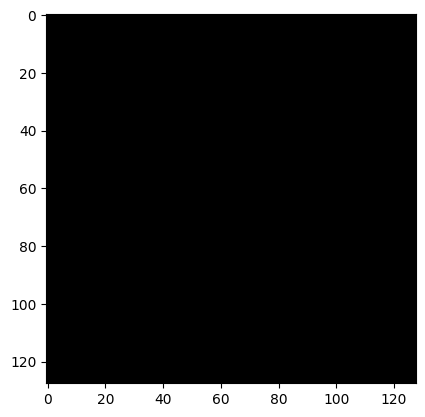

In [4]:
import cv2
import numpy as np
import tensorflow as tf

# label = cv2.imread('./Dataset/Dataset/TrainVal/label/Sphynx_112.png')
# label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

# is_black = np.all(label == [0,0,0], axis=-1)
# is_white = np.all(label == [255,255,255], axis=-1)
# is_red = (label[...,0] == 128)
# is_green = (label[...,2] == 128)

# if is_red.any():
#     is_red |= is_white
# else:
#     is_green |= is_white

# ch_1 = is_black.astype(np.uint8)
# ch_2 = is_red.astype(np.uint8)
# ch_3 = is_green.astype(np.uint8)

# output = np.stack([ch_1, ch_2, ch_3], axis=-1)

label = tf.io.read_file('./Dataset/Dataset/TrainVal/label/shiba_inu_103.png')
label = tf.io.decode_png(label, channels=3)
label = tf.image.resize(label, (128,128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
print(np.unique(label))


is_black = tf.reduce_all(tf.equal(label, [0, 0, 0]), axis=-1)
is_white = tf.reduce_all(tf.equal(label, [255, 255, 255]), axis=-1)
is_red = tf.equal(label[..., 0], 128)
is_green = tf.equal(label[..., 1], 128)
print(np.unique(is_green))

red_count = tf.reduce_sum(tf.cast(is_red, tf.int32))
green_count = tf.reduce_sum(tf.cast(is_green, tf.int32))

# Apply the logic
def turn_white_red():
    return tf.logical_or(is_red, is_white), is_green

def turn_white_green():
    return is_red, tf.logical_or(is_green, is_white)

new_is_red, new_is_green = tf.cond(red_count > green_count, turn_white_red, turn_white_green)

ch_1 = tf.cast(is_black, tf.uint8)
ch_2 = tf.cast(new_is_red, tf.uint8)
ch_3 = tf.cast(new_is_green, tf.uint8)

label = tf.stack([ch_1, ch_2, ch_3], axis=-1)

plt.imshow(label[:,:,1], cmap="gray")
print(label[:,:,2])

(3, 128, 128)
(3, 128, 128)


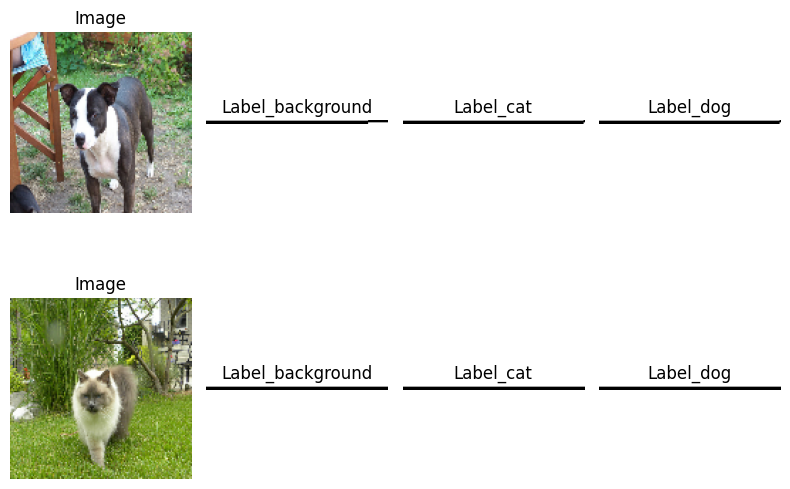

In [10]:
for img_batch, label_batch in train_ds.take(1):
    img_batch = img_batch.numpy()
    label_batch = label_batch.numpy()

    batch_size = img_batch.shape[0] 

    fig, axes = plt.subplots(batch_size, 4, figsize=(8, batch_size * 3))
    
    for i in range(batch_size):

        print(label_batch[i].shape)
        axes[i, 0].imshow(img_batch[i])
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Image")

        axes[i, 1].imshow(label_batch[i][:,:,0], cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Label_background")

        axes[i, 2].imshow(label_batch[i][:,:,1], cmap="gray")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Label_cat")

        axes[i, 3].imshow(label_batch[i][:,:,2], cmap="gray")
        axes[i, 3].axis("off")
        axes[i, 3].set_title("Label_dog")

    plt.tight_layout()
    plt.show()

In [5]:
from model import *
from tensorflow.keras.layers import Input

model = UNet(3, 0.2)

In [6]:
model(Input(shape=(128,128,3)))

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'UNet')>

In [7]:
model.summary()

Model: "UNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (DownBlock)       multiple                  39232     
                                                                 
 encoder_2 (DownBlock)       multiple                  222464    
                                                                 
 encoder_3 (DownBlock)       multiple                  887296    
                                                                 
 encoder_4 (DownBlock)       multiple                  3544064   
                                                                 
 encoder_5 (DownBlock)       multiple                  14166016  
                                                                 
 decoder_1 (UpBlock)         multiple                  8262656   
                                                                 
 decoder_2 (UpBlock)         multiple                  2066944

In [11]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import IoU
from losses import CustomLoss
import datetime

LOSS_CONF = {'dice_loss': 0.1,
             'iou_loss': 0.1,
             'focal_loss': 0.8}

loss = CustomLoss(LOSS_CONF)
optimizer = Adam(learning_rate=0.001)
iou_metrics = IoU(3, [0])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['acc'])

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=3, 
                    verbose=1,
                    callbacks=[tensorboard_callback])


Epoch 1/3


ValueError: in user code:

    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 240, in __call__
        self.build(y_pred)
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 182, in build
        self._losses = tf.nest.map_structure(
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 353, in _get_loss_object
        loss = losses_mod.get(loss)
    File "/home/diazoangga/miniconda3/envs/cvLab/lib/python3.9/site-packages/keras/losses.py", line 2668, in get
        raise ValueError(

    ValueError: Could not interpret loss function identifier: 1


In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *

def dice_coef(y_true, y_pred, smooth=1):
    numerator = 2*tf.reduce_sum(y_true * y_pred) + smooth
    denominator = tf.reduce_sum(y_true + y_pred) + smooth

    return numerator/denominator

a = tf.ones([3,4])
b = tf.random.normal([3,4])

print(dice_coef(a,b))